In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [95]:
df = pd.read_csv('../../../Project/Data/recidivism_dataset_final.csv')

In [96]:
df.columns

Index(['ID_VARIABLE', 'NEW_DOS', 'NEW_DOF', 'PRS', 'OGS', 'PRS8', 'ADJ_JPMIN',
       'LATEST_JPMIN', 'CTY_PHL', 'INCMIN', 'NEW_INC_SANCTION_EXISTS',
       'CHARGE_COUNT', 'INC_REL_NUMERIC', 'OFN_LIFE_DEATH', 'JP_LIFE_DEATH',
       'SEXCRIME', 'SEXTIER_NUMERIC', 'FIREARMS', 'VIOLENCE', 'DRUGOFFENSE',
       'DUI', 'AT_RISK_DT', 'NEXT_DOF', 'TIME_TO_RECIDIVATE', 'RECIDIVISM_3Y',
       'RECIDIVISM_5Y', 'DOB', 'OFF_RACE', 'OFF_SEX'],
      dtype='object')

In [97]:
df.head()

,ID_VARIABLE,NEW_DOS,NEW_DOF,PRS,OGS,PRS8,ADJ_JPMIN,LATEST_JPMIN,CTY_PHL,INCMIN,...,DRUGOFFENSE,DUI,AT_RISK_DT,NEXT_DOF,TIME_TO_RECIDIVATE,RECIDIVISM_3Y,RECIDIVISM_5Y,DOB,OFF_RACE,OFF_SEX
0,1000001,2010-02-18,2009-06-25,0,3.0,1.0,16.0,16.0,0,0.526316,...,0,0,2010-03-06,NaN,NaN,0,0,1990-05-28,White,M
1,1000003,2002-05-08,2001-09-07,0,3.0,2.0,0.0,0.0,0,NaN,...,1,0,2002-05-08,2009-03-04,2492.0,0,0,1961-08-14,White,F
2,1000003,2009-03-04,2009-03-04,3,3.0,3.0,92.0,92.0,0,3.000000,...,0,0,2009-06-04,NaN,NaN,0,0,1961-08-14,White,F
3,1000004,2013-12-10,2013-09-19,0,1.0,2.0,0.0,0.0,0,NaN,...,1,0,2013-12-10,2018-07-09,1672.0,0,1,1993-09-21,Unknown,M
4,1000005,2008-08-11,2006-08-14,0,3.0,1.0,183.0,183.0,0,6.000000,...,0,0,2009-02-10,NaN,NaN,0,0,1987-12-23,Black,F


In [98]:
sns.set_style(style='white') 
palette = ['#7B86BD', '#FFE347', '#F07B46', '#67E6AC', '#15B5FF' ]
race_palette = ['#7B86BD', '#FFE347', '#D3D3D3']
sns.set_palette(palette)

In [99]:
prs_labels = ['0', '1', '2', '3', '4', '5', 'RFEL/REVOC']
prs_labels_vert = ['0', '1', '2', '3', '4', '5', 'RFEL/\nREVOC']
prs8_labels =['0', 'Low', 'Medium', 'High']

In [198]:
df['NEW_DOF'] = pd.to_datetime(df['NEW_DOF'])

In [199]:
#df['NEW_DOF'].dtypes

dtype('<M8[ns]')

### Helper functions

In [101]:
def get_recidivism_rates(df, recidivism_var, level=None): 

    grp1 = 'PRS'
    grp2 = 'PRS8'
    if level is not None:
        grp1 = [grp1, level]
        grp2 = [grp2, level]
    prs = pd.DataFrame(df.groupby(by=grp1)[recidivism_var].sum() / df.groupby(by=grp1)[recidivism_var].count() * 100).reset_index()
    prs8 = pd.DataFrame(df.groupby(by=grp2)[recidivism_var].sum() / df.groupby(by=grp2)[recidivism_var].count() * 100).reset_index() 
    
    return prs, prs8

In [125]:
def get_prs_distro(df, crime_type):
    res = []
    subset = df[df[crime_type]==True] 
    for i in ['PRS', 'PRS8']:
        grouped = subset.groupby(i)['RECIDIVISM_3Y'].count() / len(subset) * 100
        res.append(grouped.reset_index())
    return res

In [102]:
def get_recidivism_flags(df, next_dof_var, new_var):
    
    df[new_var] = np.where((df[next_dof_var]- df.NEW_DOF).dt.days <= 3 * 365.25, 1, 0)
    return df

In [103]:
def get_crime_type_stats(df, crime_var, label, level = None): 
    subset = df[df[crime_var]==True].copy()
  
    rec_prs, rec_prs8 = get_recidivism_rates(subset, 'RECIDIVISM_3Y', level = level)

    # recidivate to same crime
    subset['NEXT_DOF'] = subset.sort_values(by=['ID_VARIABLE', 'NEW_DOF'], ascending = [True, True]).groupby(by=['ID_VARIABLE'])['NEW_DOF'].shift(-1) 

    subset = get_recidivism_flags(subset, next_dof_var = 'NEXT_DOF', new_var = 'RECIDIVISM_' + crime_var + '_3Y') 

    if level is None: 
        overall_rate = subset['RECIDIVISM_3Y'].sum() / len(subset)
        print("overall {:s} recidivism rate: {:.4f} %".format(label, overall_rate * 100)) 
        
        same_rate = subset['RECIDIVISM_' + crime_var + '_3Y'].sum() / len(subset) 
        print('{:s} recidivating to {:s} rate: {:.4f}%'.format(label, label, same_rate * 100)) 

    else:
        values = df[level].unique()
        for i in values:
            overall_rate = subset[subset[level]==i]['RECIDIVISM_3Y'].sum() / len(subset[subset[level]==i])
            same_rate = subset[subset[level]==i]['RECIDIVISM_' + crime_var + '_3Y'].sum() / len(subset[subset[level]==i]) 
            print('\nRecidivism rates for {:s} = {:s}:'.format(level, i))
            print("overall {:s} recidivism rate: {:.4f} %".format(label, overall_rate * 100)) 
            print('{:s} recidivating to {:s} rate: {:.4f}%'.format(label, label, same_rate * 100)) 

    rec_same_prs, rec_same_prs8 = get_recidivism_rates(subset, 'RECIDIVISM_' + crime_var + '_3Y', level = level)   

    rec_same_prs.rename(columns = {'RECIDIVISM_'+crime_var+'_3Y': 'RECIDIVISM_3Y'}, inplace=True)
    rec_same_prs8.rename(columns = {'RECIDIVISM_'+crime_var+'_3Y': 'RECIDIVISM_3Y'}, inplace=True)

    rec_same_prs['RECID_TYPE'] = label
    rec_same_prs8['RECID_TYPE'] = label

    rec_prs['RECID_TYPE'] = 'Any'
    rec_prs8['RECID_TYPE'] = 'Any' 

    prs = pd.concat([rec_prs, rec_same_prs])
    prs8 = pd.concat([rec_prs8, rec_same_prs8])

    return prs, prs8    

In [104]:
def plot_crime_type(df1, df2, category=None, legend_loc = 'upper left', 
                y = 'RECIDIVISM_3Y', 
                palette = ['#7B86BD'] * 15, ylabel='Recidivism rate (%)',
                legend_title = None, hue_order = None, ylim=None, legend_size = 13, figsize = (14, 8)):
                

    fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True, gridspec_kw={'width_ratios':[1.75,1]}) 
    sns.set_palette(palette) 

    if ylim is not None:
        plt.ylim(0, ylim)

    if category is not None:
        p1 = sns.barplot(x='PRS', y=y, hue=category, data=df1,  ax=ax[0], hue_order = hue_order)
        p2 = sns.barplot(x='PRS8', y=y, hue=category, data=df2,  ax=ax[1], hue_order = hue_order)
        if legend_loc == 'upper left':
            ax[0].legend(loc= legend_loc, title = legend_title, prop={"size": legend_size}, title_fontsize = legend_size) 
            ax[1].get_legend().remove()
        elif legend_loc == 'upper right':
            ax[1].legend(loc= legend_loc, title = legend_title, prop={"size": legend_size}, title_fontsize = legend_size) 
            ax[0].get_legend().remove()
        n_cats = len(df1[category].unique())
        for a in range(2):
            for i in range(n_cats):
                ax[a].bar_label(ax[a].containers[i], label_type='edge', fmt='%1.1f', fontsize=13)
        
    else: 
        p1 = sns.barplot(x='PRS', y=y, data=df1,  ax=ax[0])
        p2 = sns.barplot(x='PRS8', y=y, data=df2,  ax=ax[1])
        for a in range(2):
            ax[a].bar_label(ax[a].containers[0], label_type='edge', fmt='%1.1f', fontsize=13)

    sns.despine(top=True, right=True, left=True, bottom=True)

    p1.set(xticklabels = prs_labels)
    p2.set(xticklabels = prs8_labels) 
        
    p1.set_title('7th Edition', fontsize=15)
    p2.set_title('8th Edition', fontsize=15)
    plt.suptitle('PRS category', x=0.5, y=0.05, fontsize=15)
    p1.set_ylabel(ylabel, fontsize=15)
    p1.set(yticklabels=[])
    p2.set_ylabel(None)
    p2.set(yticklabels=[])
    p1.set_xlabel(None)
    p2.set_xlabel(None)

    #p1.xticks(fontsize=15)
    #p2.xticks(fontsize=15) 
    p1.tick_params(axis='both', which='major', labelsize=13)
    p2.tick_params(axis='both', which='major', labelsize=13)


    plt.subplots_adjust(wspace=0.1)
    plt.show()

In [156]:
def get_stats(df, crime_cat, category = None):
    
    subset = df[df[crime_cat]==1]
    if category is None:
        print('There are {} cases in category {}'.format(len(subset), crime_cat))
        print("These were committed by {} unique individuals".format(len(subset['ID_VARIABLE'].unique())))
    else:
        vals = subset[category].unique()
        for v in vals:
            v1 = subset[subset[category]==v]
            ids = len(v1['ID_VARIABLE'].unique())
            print("{}: There are {} {} cases committed by {} unique individuals".format(v, len(v1), crime_cat, ids))

In [115]:
df['SEXTIER_NUMERIC'].unique()

array([nan,  3.,  1.,  2.])

In [118]:
for i in ['VIOLENCE', 'DRUGOFFENSE', 'SEXCRIME', 'FIREARMS', 'DUI']:
    df[i] = np.where(df[i]==1, True, False)

### Violence

In [132]:
# PRS distros
vio_distro = get_prs_distro(df, 'VIOLENCE')

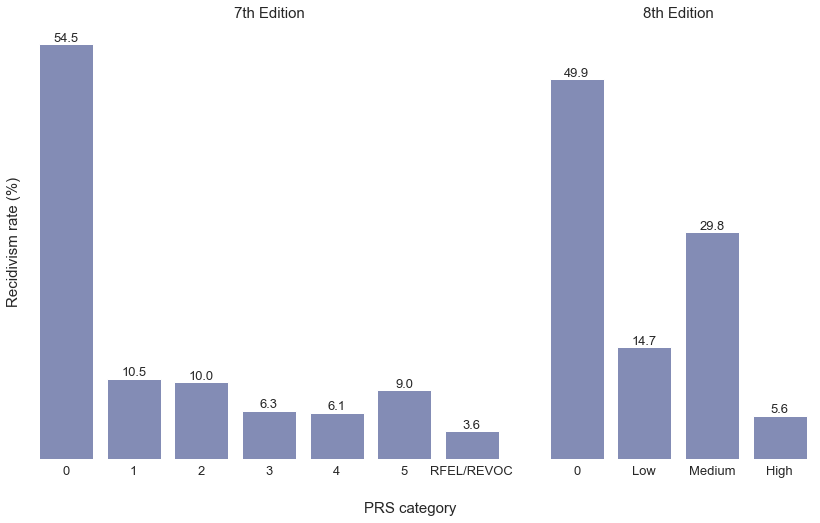

In [133]:
plot_crime_type(vio_distro[0], vio_distro[1])

In [135]:
get_stats(df, "VIOLENCE")

There are 23510 cases in category VIOLENCE
These were committed by 23031 unique individuals


### SEX TIERS

In [136]:
get_stats(df, "SEXCRIME")

There are 1055 cases in category SEXCRIME
These were committed by 1053 unique individuals


In [152]:
race_df = df[df['OFF_RACE'].isin(['Black', 'White'])]

In [158]:
get_stats(race_df, "SEXCRIME", category='OFF_RACE')

White: There are 847 SEXCRIME cases committed by 845 unique individuals
Black: There are 151 SEXCRIME cases committed by 151 unique individuals


In [129]:
# PRS distros
sex_distro = get_prs_distro(df, 'SEXCRIME')

In [143]:
df['PRS'].unique()

array([0, 3, 6, 2, 4, 5, 1], dtype=int64)

In [147]:
df[df['SEXCRIME']==1].groupby(by='PRS')['ID_VARIABLE'].count()

PRS
0    819
1     89
2     40
3     27
4     34
5     32
6     14
Name: ID_VARIABLE, dtype: int64

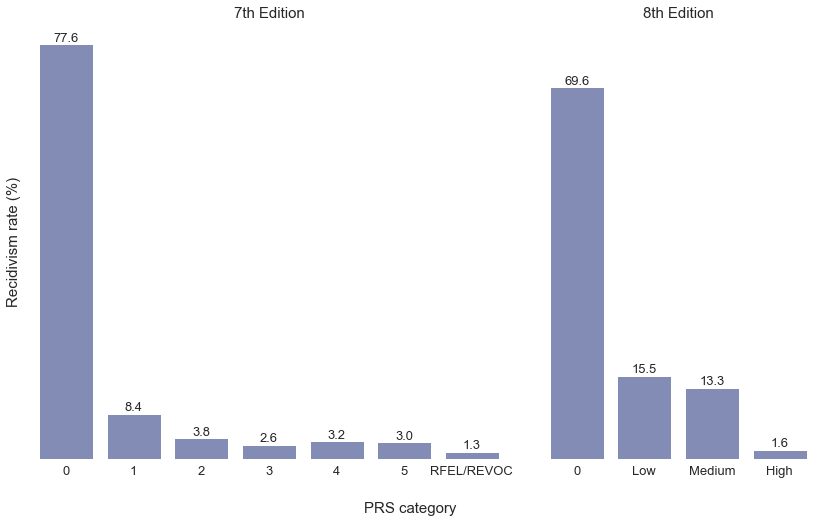

In [145]:
plot_crime_type(sex_distro[0], sex_distro[1])

In [148]:
sex_prs, sex_prs8 = get_crime_type_stats(df, 'SEXCRIME', 'Sex Crime')

overall Sex Crime recidivism rate: 10.3318 %
Sex Crime recidivating to Sex Crime rate: 0.1896%


In [210]:
#0.002 * len(sex_df)

2.11

In [177]:
sex_prs

,PRS,RECIDIVISM_3Y,RECID_TYPE
0,0,9.279609,Any
1,1,12.359551,Any
2,2,17.500000,Any
3,3,7.407407,Any
4,4,20.588235,Any
5,5,12.500000,Any
6,6,14.285714,Any
0,0,0.000000,Sex Crime
1,1,2.247191,Sex Crime
2,2,0.000000,Sex Crime


In [159]:
sex_race_prs, sex_race_prs8 = get_crime_type_stats(df[df['OFF_RACE'].isin(['Black', 'White'])], crime_var = 'SEXCRIME', label = 'Sex Crime', level = 'OFF_RACE')


Recidivism rates for OFF_RACE = White:
overall Sex Crime recidivism rate: 10.0354 %
Sex Crime recidivating to Sex Crime rate: 0.2361%

Recidivism rates for OFF_RACE = Black:
overall Sex Crime recidivism rate: 12.5828 %
Sex Crime recidivating to Sex Crime rate: 0.0000%


In [165]:
temp = df[df['SEXCRIME']==1].groupby(by='SEXTIER_NUMERIC')['ID_VARIABLE'].count()/len(df[df['SEXCRIME']==1]) * 100

In [168]:
temp = pd.DataFrame(temp).reset_index()

Text(0, 0.5, 'Percentage (%)')

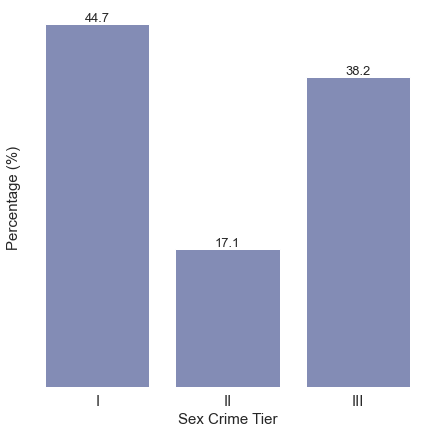

In [175]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.despine(top=True, right=True, left=True, bottom=True)

p = sns.barplot(data = temp, x='SEXTIER_NUMERIC', y='ID_VARIABLE', palette = ['#7B86BD'] * 15)
p.set_xlabel("Sex Crime Tier", fontsize=15)
p.set_xticklabels(["I", "II", 'III'], fontsize=15)
for i in range(1): 
    ax.bar_label(ax.containers[i], label_type='edge', fmt='%1.1f', fontsize=13)
p.set_yticklabels([])
p.set_ylabel("Percentage (%)", fontsize=15)


In [182]:
sex_df = df[df['SEXCRIME']==True].copy()

In [183]:
sex_tier_prs = sex_df.groupby(by=['SEXTIER_NUMERIC'])['RECIDIVISM_3Y'].sum() / sex_df.groupby(by=['SEXTIER_NUMERIC'])['RECIDIVISM_3Y'].count()

In [200]:
sex_df['NEXT_SEX_DOF'] = sex_df.sort_values(by=['ID_VARIABLE', 'NEW_DOF']).groupby(['ID_VARIABLE'])['NEW_DOF'].shift(-1)

In [202]:
sex_df['NEXT_SEX_DOF'].dtypes

dtype('<M8[ns]')

In [203]:
sex_df = get_recidivism_flags(sex_df, 'NEXT_SEX_DOF', 'RECIDIVISM_SEX')

In [204]:
sex_sex_tiers = sex_df.groupby(by=['SEXTIER_NUMERIC'])['RECIDIVISM_SEX'].sum() / sex_df.groupby(by=['SEXTIER_NUMERIC'])['RECIDIVISM_SEX'].count()

In [205]:
sex_tiers = pd.DataFrame(sex_tier_prs*100).reset_index()
sex_sex_tiers = pd.DataFrame(sex_sex_tiers*100).reset_index()

In [206]:
sex_tiers['RECID_TYPE'] = 'Any'
sex_sex_tiers['RECID_TYPE'] = 'Sex Crime'

In [207]:
sex_sex_tiers.rename(columns={"RECIDIVISM_SEX": "RECIDIVISM_3Y"}, inplace=True)

In [208]:
sex_df["RECIDIVISM_SEX"].sum()

2

In [209]:
sex_tiers_all = pd.concat([sex_tiers, sex_sex_tiers])

In [211]:
sex_tiers

,SEXTIER_NUMERIC,RECIDIVISM_3Y,RECID_TYPE
0,1.0,10.381356,Any
1,2.0,10.000000,Any
2,3.0,10.421836,Any


### Firearms

In [212]:
get_stats(df, "FIREARMS")
get_stats(race_df, 'FIREARMS', category='OFF_RACE')

There are 28263 cases in category FIREARMS
These were committed by 26991 unique individuals
White: There are 7807 FIREARMS cases committed by 7639 unique individuals
Black: There are 18166 FIREARMS cases committed by 17124 unique individuals


In [213]:
firearms_distro = get_prs_distro(df, "FIREARMS")

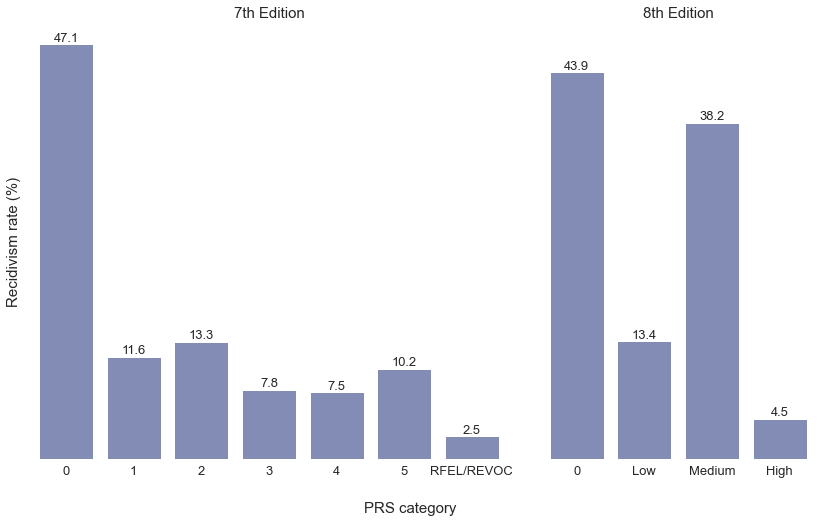

In [214]:
plot_crime_type(firearms_distro[0], firearms_distro[1])

In [215]:
firearms_prs, firearms_prs8 = get_crime_type_stats(df, 'FIREARMS', "Firearms")

overall Firearms recidivism rate: 17.4610 %
Firearms recidivating to Firearms rate: 2.6430%


In [216]:
fire_race_prs, fire_race_prs8 = get_crime_type_stats(race_df, crime_var = 'FIREARMS', label = 'Firearms', level = 'OFF_RACE')


Recidivism rates for OFF_RACE = White:
overall Firearms recidivism rate: 17.4715 %
Firearms recidivating to Firearms rate: 1.2297%

Recidivism rates for OFF_RACE = Black:
overall Firearms recidivism rate: 18.1988 %
Firearms recidivating to Firearms rate: 3.3744%


### Drug offenses

In [120]:
df['DRUGOFFENSE'].unique()
subset = df[df['DRUGOFFENSE']]

array([False,  True])

In [241]:
# PRS distros
drug_distro = get_prs_distro(df, 'DRUGOFFENSE')

In [274]:
193555/245891 

0.7871577243575405

In [244]:
get_stats(df, "DRUGOFFENSE")
get_stats(race_df, 'DRUGOFFENSE', category='OFF_RACE')

There are 315670 cases in category DRUGOFFENSE
These were committed by 245891 unique individuals
White: There are 183856 DRUGOFFENSE cases committed by 144211 unique individuals
Black: There are 109432 DRUGOFFENSE cases committed by 82849 unique individuals


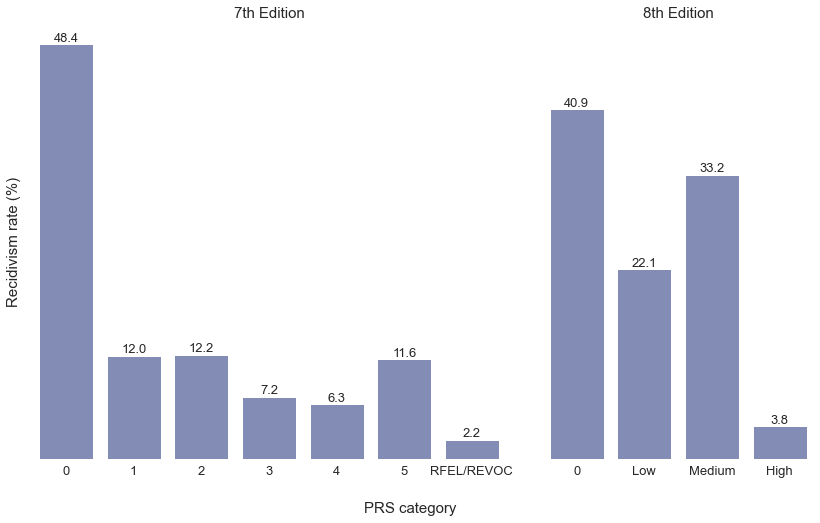

In [243]:
plot_crime_type(drug_distro[0], drug_distro[1])

In [245]:
drug_prs, drug_prs8 = get_crime_type_stats(df, 'DRUGOFFENSE', 'Drug')

overall Drug recidivism rate: 21.7106 %
Drug recidivating to Drug rate: 13.1362%


In [246]:
# overall drug recidivism rates (recidivate to any crime) by PRS
# plot_crime_type(drug_rec_prs, drug_rec_prs8)

In [247]:
# # drug crime recidivating to another drug crime 
# plot_crime_type(drug_drug_prs, drug_drug_prs8, y='RECIDIVISM_DRUG_3Y')

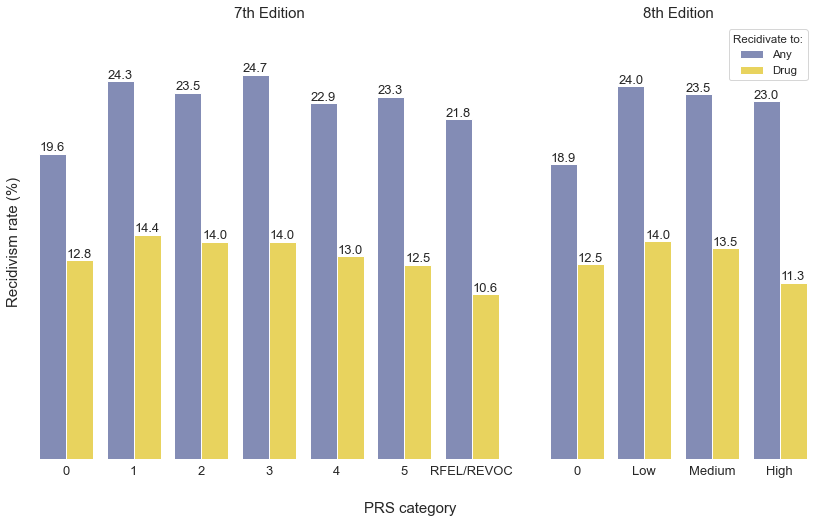

In [250]:
plot_crime_type(drug_prs, drug_prs8, category='RECID_TYPE', palette = palette,  hue_order = ['Any', 'Drug'], legend_loc = 'upper right', legend_size = 11.5, legend_title='Recidivate to:', ylim=28)

In [251]:
drug_race_prs, drug_race_prs8 = get_crime_type_stats(df[df['OFF_RACE'].isin(['Black', 'White'])], crime_var = 'DRUGOFFENSE', label = 'Drug', level = 'OFF_RACE')


Recidivism rates for OFF_RACE = White:
overall Drug recidivism rate: 22.5840 %
Drug recidivating to Drug rate: 13.0755%

Recidivism rates for OFF_RACE = Black:
overall Drug recidivism rate: 21.8227 %
Drug recidivating to Drug rate: 13.9968%


Plotting results for recidiviating to Any crime


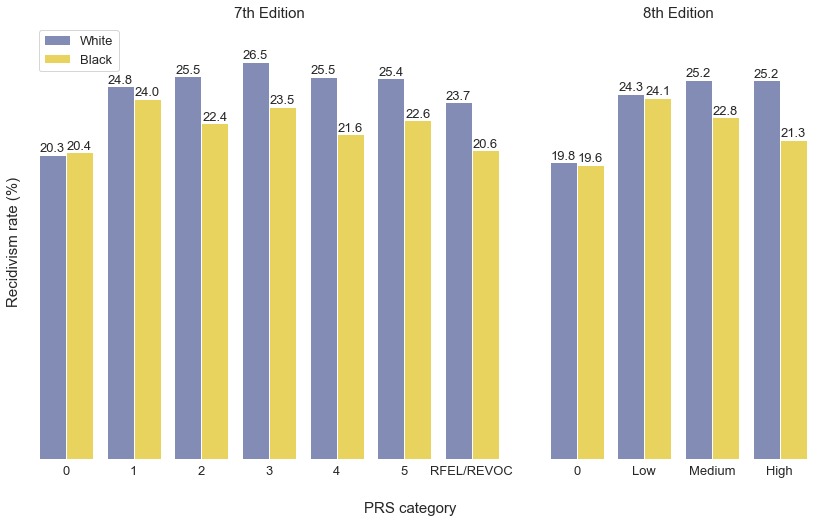

Plotting results for recidiviating to Drug crime


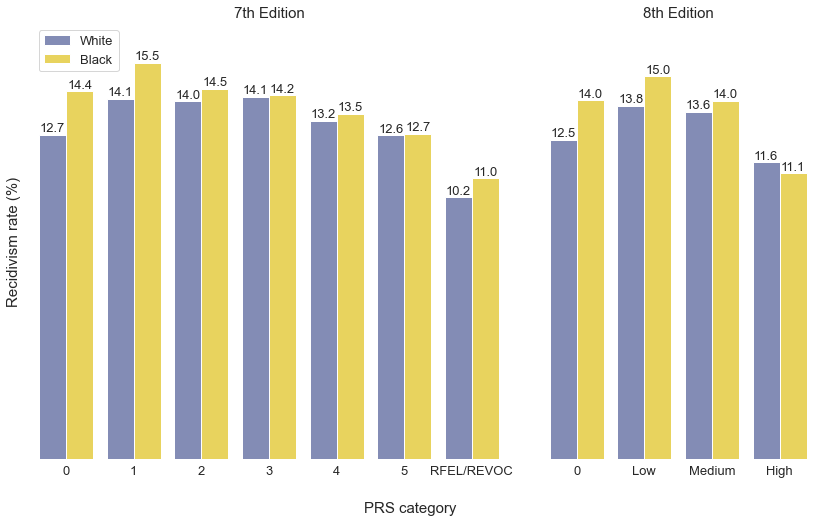

In [261]:
# recidivating to any crime
ylim = [29, 17]
types = ['Any', 'Drug']
for i in range(len(types)):
    t = types[i]
    print('Plotting results for recidiviating to {} crime'.format(t))
    plot_crime_type(drug_race_prs[drug_race_prs['RECID_TYPE'] == t], drug_race_prs8[drug_race_prs8['RECID_TYPE'] == t], 
    palette = race_palette, hue_order = ['White', 'Black'], category='OFF_RACE', legend_loc = 'upper left', ylim = ylim[i])

In [ ]:
# # drug offenses by race

# def plot_crime_type(df1, df2, category=None, legend_loc = 'upper left', 
#                 x = 'PRS', y = 'RECIDIVISM_3Y', 
#                 palette = ['#7B86BD'] * 15, ylabel='Recidivism rate (%)',
#                 legend_title = None, hue_order = None, ylim=None, legend_size = 13, figsize = (14, 8)): 

### Drug MISD

In [266]:
df['DRUGMISD']=False

In [269]:
df.loc[(df['DRUGOFFENSE']==True) & (df['OGS']<=4), 'DRUGMISD']=True

In [271]:
df['DRUGMISD']

0          False
1           True
2          False
3           True
4          False
           ...  
1216233    False
1216234    False
1216235    False
1216236    False
1216237    False
Name: DRUGMISD, Length: 1216238, dtype: bool

In [272]:
get_stats(df, "DRUGMISD")
get_stats(df[df['OFF_RACE'].isin(['Black', 'White'])], 'DRUGMISD', category='OFF_RACE')

There are 193555 cases in category DRUGMISD
These were committed by 158480 unique individuals
White: There are 130105 DRUGMISD cases committed by 105916 unique individuals
Black: There are 53457 DRUGMISD cases committed by 43852 unique individuals


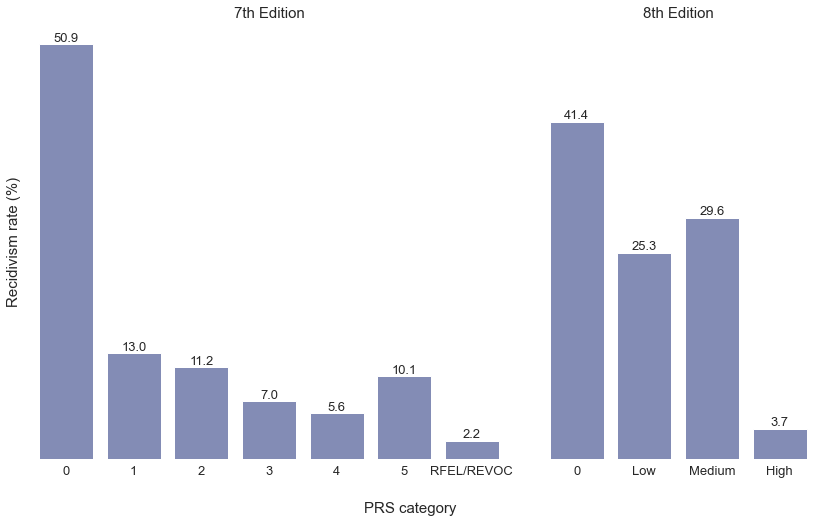

In [273]:
drugmisd_distro = get_prs_distro(df, 'DRUGMISD')
plot_crime_type(drugmisd_distro[0], drugmisd_distro[1])

In [276]:
misd_prs, misd_prs8 = get_crime_type_stats(df, 'DRUGMISD', 'Drug Misd.')

overall Drug Misd. recidivism rate: 24.6529 %
Drug Misd. recidivating to Drug Misd. rate: 11.1886%


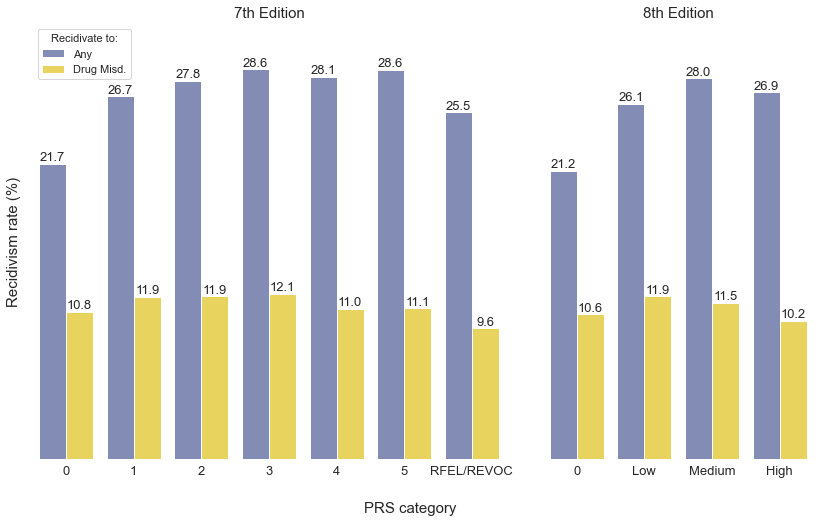

In [281]:
plot_crime_type(misd_prs, misd_prs8, category='RECID_TYPE', palette = palette,  hue_order = ['Any', 'Drug Misd.'], legend_loc = 'upper left', legend_size = 11, legend_title='Recidivate to:', ylim=32)

### DUIs

In [282]:
get_stats(df, "DUI")
get_stats(df[df['OFF_RACE'].isin(['Black', 'White'])], 'DUI', category='OFF_RACE')

There are 251777 cases in category DUI
These were committed by 218414 unique individuals
White: There are 212737 DUI cases committed by 183518 unique individuals
Black: There are 28149 DUI cases committed by 24789 unique individuals


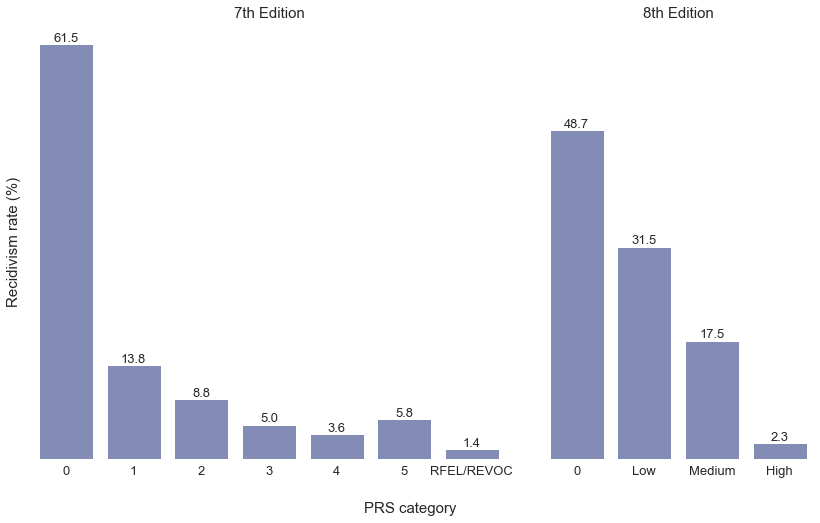

In [283]:
dui_distro = get_prs_distro(df, 'DUI')
plot_crime_type(dui_distro[0], dui_distro[1])

In [284]:
dui_prs, dui_prs8 = get_crime_type_stats(df, 'DUI', 'DUI')

overall DUI recidivism rate: 13.1871 %
DUI recidivating to DUI rate: 7.3931%


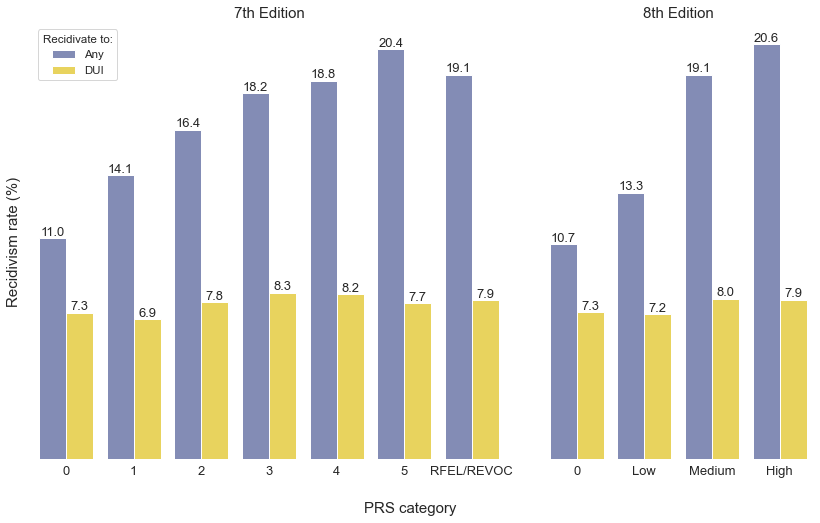

In [285]:
plot_crime_type(dui_prs, dui_prs8, category='RECID_TYPE', palette = palette,  hue_order = ['Any', 'DUI'], legend_loc = 'upper left', legend_size = 11.5, legend_title='Recidivate to:')

In [286]:
# DUI by race

dui_race_prs, dui_race_prs8 = get_crime_type_stats(df[df['OFF_RACE'].isin(['Black', 'White'])], crime_var = 'DUI', label = 'DUI', level = 'OFF_RACE')


Recidivism rates for OFF_RACE = White:
overall DUI recidivism rate: 12.9460 %
DUI recidivating to DUI rate: 7.5803%

Recidivism rates for OFF_RACE = Black:
overall DUI recidivism rate: 16.9491 %
DUI recidivating to DUI rate: 7.0162%


Plotting results for recidiviating to Any crime


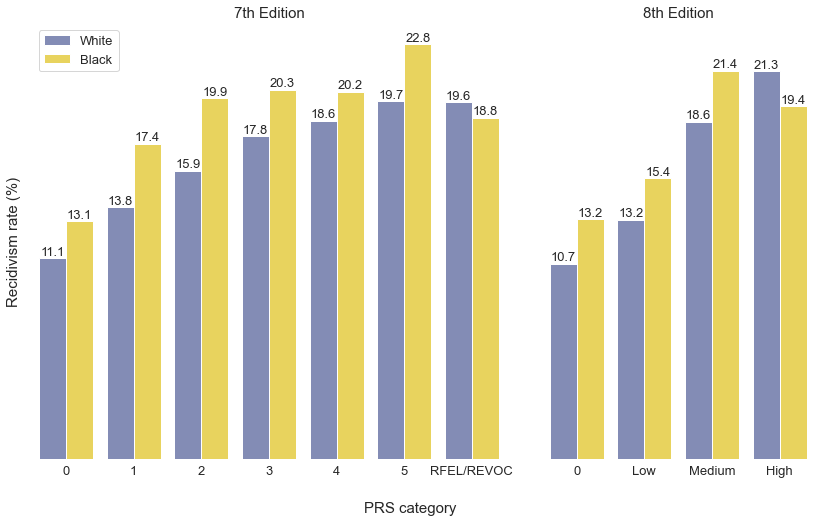

Plotting results for recidiviating to DUI crime


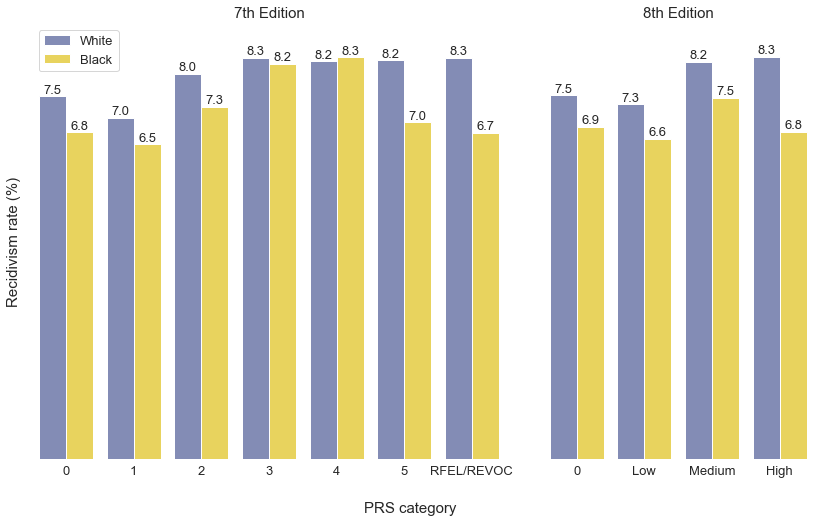

In [289]:
# recidivating to any crime
ylim = [None, 9]
types = ['Any', 'DUI']
for i in range(len(types)):
    t = types[i]
    print('Plotting results for recidiviating to {} crime'.format(t))
    plot_crime_type(dui_race_prs[dui_race_prs['RECID_TYPE'] == t], dui_race_prs8[dui_race_prs8['RECID_TYPE'] == t], 
    palette = race_palette, hue_order = ['White', 'Black'], category='OFF_RACE', legend_loc = 'upper left', ylim = ylim[i])

### Felony

In [220]:
df['FELONY'] = np.where(df['OGS']>=5, True, False)

In [221]:
df['PRS'].unique()

array([0, 3, 6, 2, 4, 5, 1], dtype=int64)

In [233]:
get_stats(df, "FELONY")
get_stats(df[df['OFF_RACE'].isin(['Black', 'White'])], 'FELONY', category='OFF_RACE')

There are 364101 cases in category FELONY
These were committed by 306557 unique individuals
White: There are 218690 FELONY cases committed by 185509 unique individuals
Black: There are 117974 FELONY cases committed by 96761 unique individuals


In [235]:
fel_distro = get_prs_distro(df, 'FELONY')

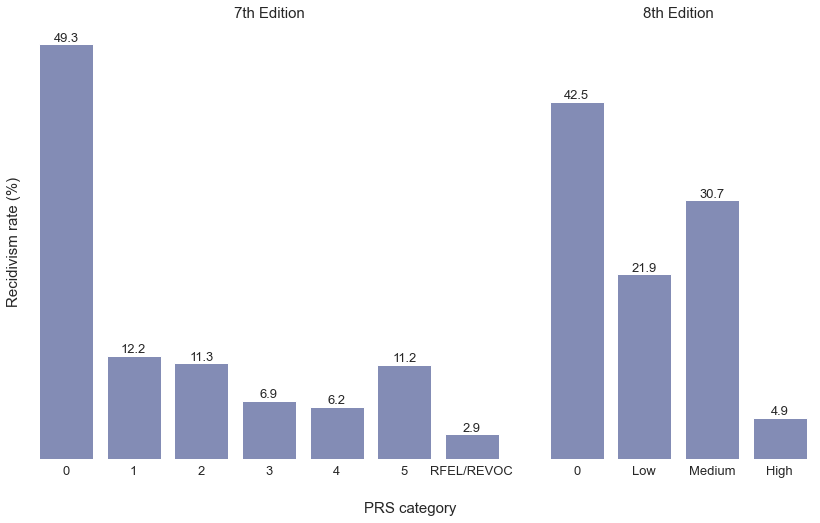

In [236]:
plot_crime_type(fel_distro[0], fel_distro[1])

In [237]:
fel_prs, fel_prs8 = get_crime_type_stats(df, 'FELONY', 'Felony')

overall Felony recidivism rate: 15.4257 %
Felony recidivating to Felony rate: 8.5737%


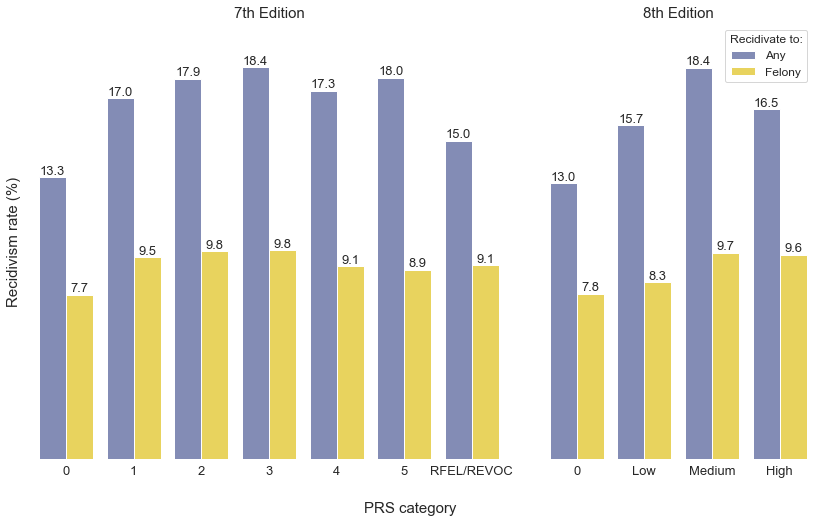

In [238]:
plot_crime_type(fel_prs, fel_prs8, category='RECID_TYPE', palette = palette,  hue_order = ['Any', 'Felony'],  ylim = 20.5, legend_loc = 'upper right', legend_size = 12, legend_title='Recidivate to:')

In [239]:
# Felony by race
fel_race_prs, fel_race_prs8 = get_crime_type_stats(df[df['OFF_RACE'].isin(['Black', 'White'])], crime_var = 'FELONY', label = 'Felony', level = 'OFF_RACE')


Recidivism rates for OFF_RACE = White:
overall Felony recidivism rate: 15.3034 %
Felony recidivating to Felony rate: 8.3301%

Recidivism rates for OFF_RACE = Black:
overall Felony recidivism rate: 16.9207 %
Felony recidivating to Felony rate: 9.5021%


Plotting results for recidiviating to Any crime


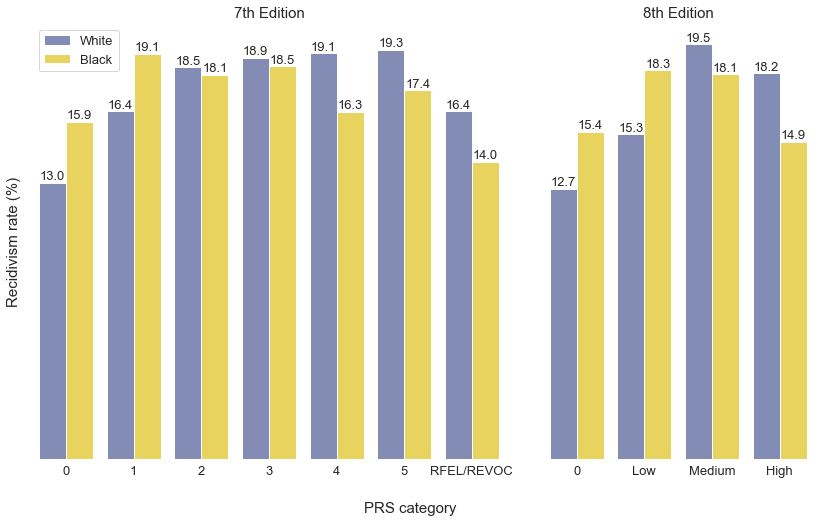

Plotting results for recidiviating to Felony crime


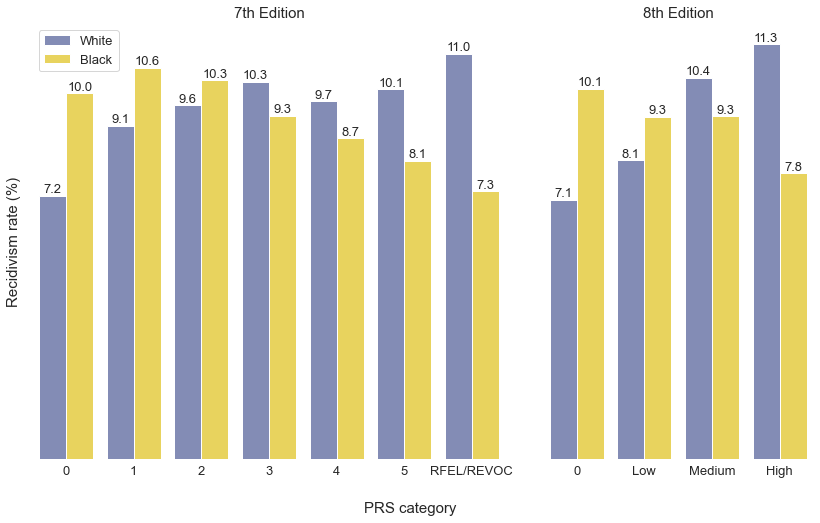

In [240]:
# recidivating to any crime
ylim = [None, None]
types = ['Any', 'Felony']
for i in range(len(types)):
    t = types[i]
    print('Plotting results for recidiviating to {} crime'.format(t))
    plot_crime_type(fel_race_prs[fel_race_prs['RECID_TYPE'] == t], fel_race_prs8[fel_race_prs8['RECID_TYPE'] == t], 
    palette = race_palette, hue_order = ['White', 'Black'], category='OFF_RACE', legend_loc = 'upper left', ylim = ylim[i])